<a href="https://colab.research.google.com/github/vollmerale22/Computational-modelling-of-behaviour-/blob/main/Prospect_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prospect Theory

In the experimental design we want to model prospect theory parameters. In particular, we use simplex theory to create a design suitable to recover prospect theory value parameters (ie risk attitude in gain, risk attitude in loss, loss aversion) and choice temperature (we are excluding the probability distortion function here).


Note: In the first code snippet, loss aversion is not accurately recovered - hence I simulate and recover it at the end of this code more precisely

<ipython-input-28-124113020bf7>:10: RuntimeWarning:

invalid value encountered in power

<ipython-input-28-124113020bf7>:11: RuntimeWarning:

invalid value encountered in power

<ipython-input-28-124113020bf7>:50: RuntimeWarning:

invalid value encountered in power

<ipython-input-28-124113020bf7>:51: RuntimeWarning:

invalid value encountered in power



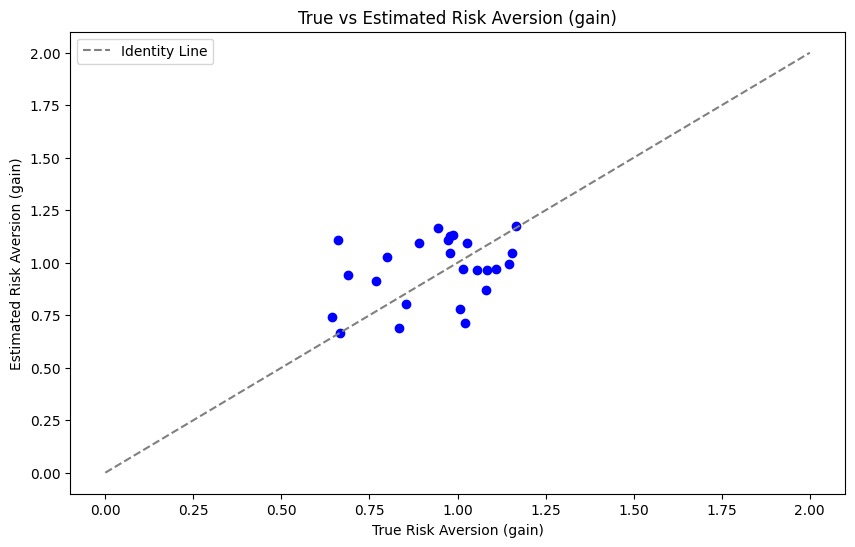

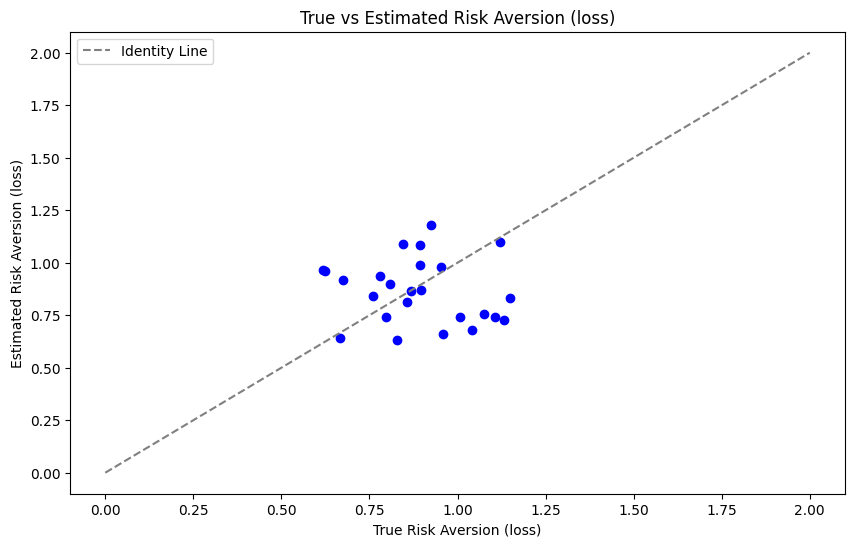

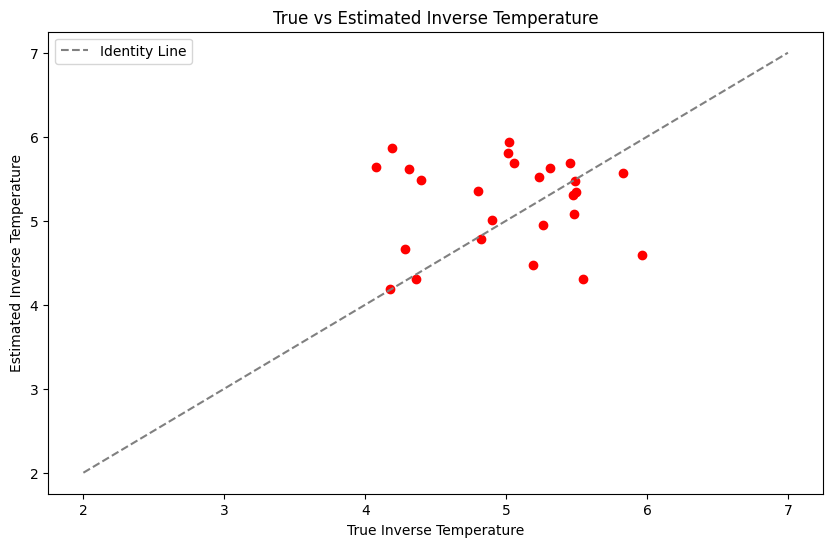

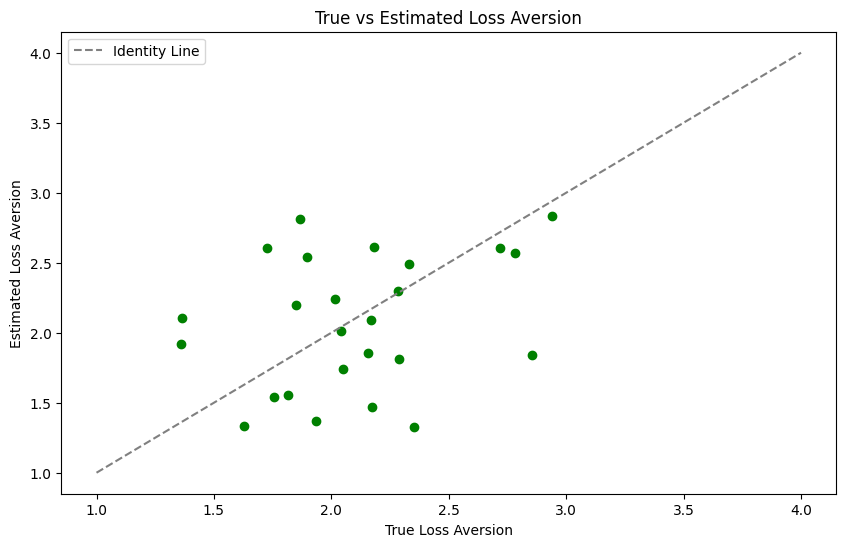

In [ ]:
# alpha = risk attitude in gain, beta = risk attitude in loss, lambda = loss aversion
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product,combinations

def choices_simulation(params, lotteries):
    alpha, beta, lambda_loss, inv_temp = params
    utilities = np.where(lotteries[:, 1] >= 0,
                         lotteries[:, 0] * (lotteries[:, 1] ** alpha),
                         -lambda_loss * lotteries[:, 0] * (-(lotteries[:, 1]) ** beta))
    utilitySaf = np.zeros(len(lotteries)) * safeOption
    probabilities = np.exp(utilities * inv_temp) / (np.exp(utilities * inv_temp) + np.exp(utilitySaf * inv_temp))
    probabilities = np.clip(probabilities, 1e-6, 1 - 1e-6)
    choices = np.random.rand(len(probabilities)) < probabilities
    return choices.astype(int)


# Number of agents and lotteries
num_agents = 25

# Generate synthetic data for lottery choices for multiple agents
lProbas = np.arange(0.1,0.9,0.1)
lOutcome = np.arange(-10,10,1)
lotteries = np.array(list(product(lProbas, lOutcome)))
safeOption = 0;

# Arrays to store true and estimated parameters
true_params = np.zeros((num_agents, 4))
estimated_params = np.zeros((num_agents, 4))

# Simulate choices and estimate parameters for each agent
for i in range(num_agents):
    # True parameters for the current agent
    true_alpha = np.random.uniform(0.6, 1.2)
    true_beta = np.random.uniform(0.6, 1.2)
    true_lambda = np.random.uniform(1.3, 3)
    true_inv_temp = np.random.uniform(4, 6)
    true_params[i, :] = [true_alpha, true_beta, true_lambda, true_inv_temp]


    # Simulate choices for the current agent
    choices = choices_simulation(true_params[i, :], lotteries)


    # Define utility function
    def utility_function(params, lotteries, choices):
      alpha, beta, lambda_loss, inv_temp = params
      utilities = np.where(lotteries[:, 1] >= 0,
                           lotteries[:, 0] * (lotteries[:, 1] ** alpha),
                           -lambda_loss * lotteries[:, 0] * (-(lotteries[:, 1]) ** beta))
      utilitySaf = np.zeros(len(lotteries)) * safeOption
      probabilities = np.exp(utilities * inv_temp) / (np.exp(utilities * inv_temp) + np.exp(utilitySaf * inv_temp))
      probabilities = np.clip(probabilities, 1e-6, 1 - 1e-6)
      neg_log_likelihood = -np.sum(choices * np.log(probabilities) + (1 - choices) * np.log(1 - probabilities))
      return neg_log_likelihood

    # Initial guess for parameters
    initial_guess = np.array([np.random.uniform(0.6, 1.2),np.random.uniform(0.6, 1.2), np.random.uniform(1.3,3), np.random.uniform(4,6)])
    bounds = [(0.5, 2.5), (0.5, 2.5), (1,3.5), (3.8, 6.2)]
    # Run the Nelder-Mead optimization algorithm
    result = minimize(utility_function, initial_guess, args=(lotteries, choices), method='Nelder-Mead',bounds=bounds)
    # Extract the optimal parameters
    estimated_params[i, :] = result.x
    minLL = -result.fun
    # Best log-likelihood (negative because we minimize)

# Plot the true vs estimated parameters for risk aversion (gain)
plt.figure(figsize=(10, 6))
plt.scatter(true_params[:, 0], estimated_params[:, 0], color='b', marker='o')
plt.plot([0, 2], [0, 2], linestyle='--', color='gray', label='Identity Line')
plt.xlabel('True Risk Aversion (gain)')
plt.ylabel('Estimated Risk Aversion (gain)')
plt.title('True vs Estimated Risk Aversion (gain)')
plt.legend()
plt.show()

# Plot the true vs estimated parameters for risk aversion (loss)
plt.figure(figsize=(10, 6))
plt.scatter(true_params[:, 1], estimated_params[:, 1], color='b', marker='o')
plt.plot([0, 2], [0, 2], linestyle='--', color='gray', label='Identity Line')
plt.xlabel('True Risk Aversion (loss)')
plt.ylabel('Estimated Risk Aversion (loss)')
plt.title('True vs Estimated Risk Aversion (loss)')
plt.legend()
plt.show()

# Plot the true vs estimated parameters for inverse temperature
plt.figure(figsize=(10, 6))
plt.scatter(true_params[:, 3], estimated_params[:, 3], color='r', marker='o')
plt.plot([2, 7], [2, 7], linestyle='--', color='gray', label='Identity Line')
plt.xlabel('True Inverse Temperature')
plt.ylabel('Estimated Inverse Temperature')
plt.title('True vs Estimated Inverse Temperature')
plt.legend()
plt.show()

# Plot the true vs estimated parameters for loss aversion (lambda)
plt.figure(figsize=(10, 6))
plt.scatter(true_params[:, 2], estimated_params[:, 2], color='g', marker='o')
plt.plot([1,4], [1, 4], linestyle='--', color='gray', label='Identity Line')
plt.xlabel('True Loss Aversion')
plt.ylabel('Estimated Loss Aversion')
plt.title('True vs Estimated Loss Aversion')
plt.legend()
plt.show()

### Grid Search (only for gain domain and one person only)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
# Generate synthetic data for lottery choices for multiple agents
lProbas = np.arange(0.1,0.9,0.1)
lOutcome = np.arange(1,10,1)  # changed this to positive outcomes for the grid search
lotteries = np.array(list(product(lProbas, lOutcome)))

def choices_simulation(params, lotteries):
    alpha, inv_temp = params
    utilities = lotteries[:, 0] * (lotteries[:, 1] ** alpha)
    utilitySaf = np.zeros(len(lotteries))  # Assuming a safe option utility of 0 for simplicity
    probabilities = np.exp(utilities * inv_temp) / (np.exp(utilities * inv_temp) + np.exp(utilitySaf * inv_temp))
    probabilities = np.clip(probabilities, 1e-10, 1 - 1e-10)  # Avoid log(0) and log(1) issues
    choices = np.random.rand(len(probabilities)) < probabilities
    return choices.astype(int)

# Define utility function for grid search
def utility_function(params, lotteries, choices):
    alpha, inv_temp = params
    utilities = lotteries[:, 0] * (lotteries[:, 1] ** alpha)
    utilitySaf = np.zeros(len(lotteries))
    probabilities = np.exp(utilities * inv_temp) / (np.exp(utilities * inv_temp) + np.exp(utilitySaf * inv_temp))
    probabilities = np.clip(probabilities, 1e-10, 1 - 1e-10)  # Avoid log(0) and log(1) issues
    neg_log_likelihood = -np.sum(choices * np.log(probabilities) + (1 - choices) * np.log(1 - probabilities))
    return neg_log_likelihood

# Grid search parameters
alpha_range = np.linspace(0.5, 1.5, 21)
inv_temp_range = np.linspace(2, 6, 21)
param_combinations = list(product(alpha_range, inv_temp_range))

# Placeholder for best parameters and minimum negative log-likelihood
best_params = None
min_neg_log_likelihood = np.inf

choices = choices_simulation([true_alpha, true_inv_temp], lotteries)

for params in param_combinations:
    neg_log_likelihood = utility_function(params, lotteries, choices)
    if neg_log_likelihood < min_neg_log_likelihood:
        min_neg_log_likelihood = neg_log_likelihood
        best_params = params

print(f"Best parameters: alpha = {best_params[0]}, inv_temp = {best_params[1]}")
print(f"Minimum negative log-likelihood: {min_neg_log_likelihood}")


Best parameters: alpha = 1.15, inv_temp = 3.4000000000000004
Minimum negative log-likelihood: 8.49467422721008


In [ ]:
import plotly.graph_objects as go
# Initialize an array to store negative log-likelihood values for each combination
nll_values = np.zeros((len(alpha_range), len(inv_temp_range)))

# Update the loop to store NLL values
for i, (alpha, inv_temp) in enumerate(param_combinations):
    nll = utility_function([alpha, inv_temp], lotteries, choices)
    nll_values[i // len(inv_temp_range)][i % len(inv_temp_range)] = nll


# Create meshgrids for the alpha and inverse temperature values
X, Y = np.meshgrid(alpha_range, inv_temp_range)

# Convert the NLL values matrix to match the shape of the meshgrid for plotting
Z = nll_values.T  # Transpose to match the plotting grid

# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

# Mark the best parameters with a distinct marker
fig.add_trace(go.Scatter3d(x=[best_params[0]],
                           y=[best_params[1]],
                           z=[min_neg_log_likelihood],
                           mode='markers',
                           marker=dict(size=5, color='red'),
                           name='Best Parameters'))

# Set the layout for the plot
fig.update_layout(title='',
                  scene=dict(xaxis_title='Alpha (Risk Attitude in Gain)',
                             yaxis_title='Inverse Temperature',
                             zaxis_title='Negative Log-Likelihood',
                             aspectratio=dict(x=1, y=1, z=0.7),
                             aspectmode='manual'),
                  autosize=False,
                  width=800,
                  height=600)

fig.show()

In [ ]:
### Here I do the same but for multiple agents
num_agents = 25  # Number of agents
agents_best_params = np.zeros((num_agents, 2))  # Store best parameters for each agent
agents_min_neg_log_likelihood = np.zeros(num_agents)  # Store min NLL for each agent

# Loop over each agent to simulate choices and conduct a grid search
for i in range(num_agents):
    # Generate synthetic choices for the current agent
    choices = choices_simulation([true_alpha, true_inv_temp], lotteries)

    # Grid search parameters
    alpha_range = np.linspace(0.5, 1.5, 21)
    inv_temp_range = np.linspace(2, 6, 21)
    param_combinations = list(product(alpha_range, inv_temp_range))

    # Placeholder for best parameters and minimum negative log-likelihood for the current agent
    best_params = None
    min_neg_log_likelihood = np.inf

    # Conduct grid search for the current agent
    for params in param_combinations:
        neg_log_likelihood = utility_function(params, lotteries, choices)
        if neg_log_likelihood < min_neg_log_likelihood:
            min_neg_log_likelihood = neg_log_likelihood
            best_params = params

    # Store the results for the current agent
    agents_best_params[i] = best_params
    agents_min_neg_log_likelihood[i] = min_neg_log_likelihood

    #print out the results for the current agent
    print(f"Agent {i}: Best parameters: alpha = {best_params[0]}, inv_temp = {best_params[1]}")
    print(f"Agent {i}: Minimum negative log-likelihood: {min_neg_log_likelihood}")


Agent 0: Best parameters: alpha = 0.95, inv_temp = 3.8
Agent 0: Minimum negative log-likelihood: 9.278534059337279
Agent 1: Best parameters: alpha = 0.75, inv_temp = 6.0
Agent 1: Minimum negative log-likelihood: 5.522904958711676
Agent 2: Best parameters: alpha = 0.8500000000000001, inv_temp = 4.4
Agent 2: Minimum negative log-likelihood: 8.86579584200001
Agent 3: Best parameters: alpha = 0.8, inv_temp = 6.0
Agent 3: Minimum negative log-likelihood: 5.103334432219642
Agent 4: Best parameters: alpha = 1.5, inv_temp = 4.4
Agent 4: Minimum negative log-likelihood: 4.565953301364429
Agent 5: Best parameters: alpha = 1.25, inv_temp = 6.0
Agent 5: Minimum negative log-likelihood: 2.905134358525268
Agent 6: Best parameters: alpha = 1.5, inv_temp = 6.0
Agent 6: Minimum negative log-likelihood: 1.9029859307145534
Agent 7: Best parameters: alpha = 1.25, inv_temp = 6.0
Agent 7: Minimum negative log-likelihood: 3.5051343585252686
Agent 8: Best parameters: alpha = 0.5, inv_temp = 3.8
Agent 8: Minim

## Recovery of loss aversion
The only way to recover loss aversion is to vary the magnitude of lottery gains and losses and determine the ratio between the best and the worst lottery outcome.


In [ ]:
import numpy as np
from scipy.optimize import minimize

def prospect_theory_value(gain, loss, lambda_loss):
    if gain > 0:
        v_gain = gain  # alpha = 1
    else:
        v_gain = 0

    if loss < 0:
        v_loss = -lambda_loss * abs(loss)  # beta = 1
    else:
        v_loss = 0

    return v_gain + v_loss

def simulate_choices(gambles, lambda_loss, bias):
    choices = []
    for gain, loss in gambles:
        v_accept = prospect_theory_value(gain, loss, lambda_loss)
        p_accept = 1 / (1 + np.exp(-(bias + v_accept)))  # Applying Luce's choice rule
        choice = np.random.rand() < p_accept
        choices.append(int(choice))
    return np.array(choices)

def neg_log_likelihood(params, gambles, choices):
    lambda_loss, bias = params
    likelihoods = []
    for i, (gain, loss) in enumerate(gambles):
        v_accept = prospect_theory_value(gain, loss, lambda_loss)
        p_accept = 1 / (1 + np.exp(-(bias + v_accept)))
        likelihood = choices[i] * np.log(p_accept) + (1 - choices[i]) * np.log(1 - p_accept)
        likelihoods.append(likelihood)
    return -np.sum(likelihoods)

# Define parameters for the simulation
true_lambda_loss = 2.25
true_bias = 0.1

# Generate a set of mixed gambles
gains = np.arange(2, 21, 2)
losses = -np.arange(2, 21, 2)
gambles = [(gain, loss) for gain in gains for loss in losses]

# Simulate choices for these gambles
choices = simulate_choices(gambles, true_lambda_loss, true_bias)

# Initial guesses and bounds
initial_guess = [1.0, 0]  # Initial guess for lambda_loss and bias
bounds = [(0.1, 5), (-1, 1)]  # Reasonable bounds

# Use the Nelder-Mead method to estimate parameters
result = minimize(neg_log_likelihood, initial_guess, args=(gambles, choices),
                  method='Nelder-Mead', bounds=bounds)

estimated_lambda_loss, estimated_bias = result.x

print(f"True parameters: lambda_loss = {true_lambda_loss}, bias = {true_bias}")
print(f"Estimated parameters: lambda_loss = {estimated_lambda_loss:.2f}, bias = {estimated_bias:.2f}")



True parameters: lambda_loss = 2.25, bias = 0.1
Estimated parameters: lambda_loss = 2.43, bias = 0.13


In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Function to calculate the value according to Prospect Theory
def pt_value(gain, loss, lambda_loss):
    if gain > 0:
        v_gain = gain  # assume alpha=beta=1
    else:
        v_gain = 0
    if loss < 0:
        v_loss = -lambda_loss * abs(loss)  # since alpha=beta=1
    else:
        v_loss = 0
    return 0.5 * v_gain + 0.5 * v_loss  # w(1/2) = 0.5 assumed

# Function to simulate choices based on PT value and a bias
def simulate_choices(gambles, lambda_loss, bias=0):
    choices = []
    for gain, loss in gambles:
        v_accept = pt_value(gain, loss, lambda_loss) + bias
        # Simplification: Directly compare PT value to 0 (status quo) to decide
        choice = int(v_accept > 0)
        choices.append(choice)
    return np.array(choices)

# Negative log-likelihood function
def neg_log_likelihood(params, gambles, observed_choices):
    lambda_loss, bias = params
    nll = 0
    for i, (gain, loss) in enumerate(gambles):
        v_accept = pt_value(gain, loss, lambda_loss) + bias
        p_accept = 1 / (1 + np.exp(-v_accept))  # Assuming V(reject)=0
        if observed_choices[i] == 1:
            nll -= np.log(p_accept)
        else:
            nll -= np.log(1 - p_accept)
    return nll
# Gambles setup
gains = np.arange(2, 21, 2)
losses = -np.arange(2, 21, 2)
gambles = [(gain, loss) for gain in gains for loss in losses]

true_lambdas = np.random.uniform(1.3, 3, 50)  # True lambda values for simulations
recovered_lambdas = []  # To store recovered lambda values
recovered_bias = []  # To store recovered bias values

for lambda_loss in true_lambdas:
    observed_choices = simulate_choices(gambles, lambda_loss, bias=0.1)
    result = minimize(neg_log_likelihood, [1, 0], args=(gambles, observed_choices), bounds=[(0, None), (None, None)])
    recovered_lambdas.append(result.x[0])
    recovered_bias.append(result.x[1])

# Convert lists to arrays
recovered_lambdas = np.array(recovered_lambdas)
recovered_bias = np.array(recovered_bias)


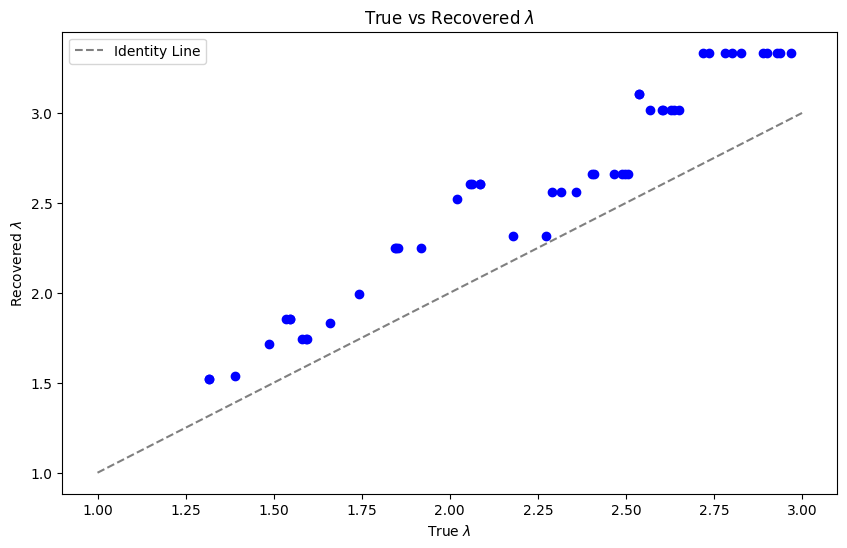

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(true_lambdas, recovered_lambdas, color='blue')
plt.plot([1, 3], [1, 3], linestyle='--', color='gray', label='Identity Line')  # Ideal line where estimated = true
plt.xlabel('True $\lambda$')
plt.ylabel('Recovered $\lambda$')
plt.title('True vs Recovered $\lambda$')
plt.legend()
plt.show()
